## Load libraries and necessary data files

In [1]:
library(data.tree)
library(data.table)
library(pracma)
load('../data/mutation_type_pd.rda')

In [2]:
names(pdfinal) <- c('P_driver','P_passenger','P_null')
pdfinal

P_driver P_passenger      P_null 
0.001094647 0.018984124 0.979921230

In [3]:
birthrate <- function(nd, np, sd, sp) {
    
    
    return(((1+sd)^nd)/((1+sp)^np))
            
}

In [4]:
delta_ncells <- function(B, D, tau, ncells) {
    
    return (max(ncells + rbinom(1,ncells,min(B*tau,1))-rbinom(1,ncells,min(D*tau,1)),0))
    
}

### Define parameters

In [10]:
#--- Set simulation parameters
N0 <-  1e3         # Initial number of cells
mu  <- 0.8         # Probability of transposition per generation per cell
tau <- 0.5         # Generations per timestep

NT <- 500          # Number of time steps

maxNClones <- 1000 # Maximum number of clones buffer

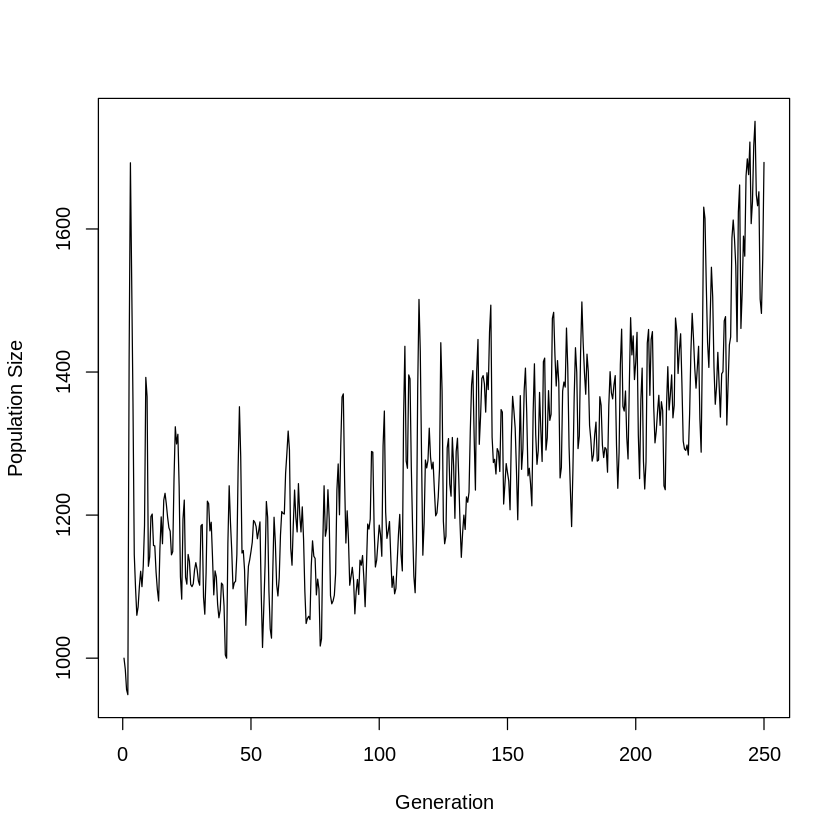

In [11]:
# for (jj in 1:5) {
Pop <- data.table(ncells=rep(0,maxNClones),nd=rep(0,maxNClones),np=rep(0,maxNClones),B=rep(0,maxNClones))
Pop[1]$ncells = N0
Pop[1]$nd = 0
Pop[1]$np = 0
Pop[1]$B = 1
# head(Pop)

sd <- 0.1
sp <- 0.1
N <- rep(0,NT)

for (ii in 1:NT) {

    N[ii] <- sum(Pop$ncells) # get current number of cells
    if (N[ii]>5*N0) {
        break
    }
    D <- N[ii]/N0            # compute death rate
    ntrans <- rbinom(1,N[ii],mu*tau) # sample total number of transpositions for current timestep
    if (ntrans > 0) {
        types <- sample(1:3,ntrans,replace=TRUE,prob=pdfinal) # sample mutation types
        if (length(which(types!=3))>0) { # if any passenger or driver mutations
            types <- types[types!=3] # reduce array of types to only passenger and drivers
            nmu <- length(types) # get total number of passenger and drivers
            ctrans <- sample(1:maxNClones,nmu,replace=TRUE,prob=Pop$ncells/N[ii]) # samples clones nmu times with replacement, with probability determined by clone size
            transids <- as.numeric(names(table(ctrans))) # get clones that were sampled
            Pop[transids]$ncells <- max(Pop[transids]$ncells - as.numeric(table(ctrans)),0) # remove cells from sampled clones
            tmp <- which(Pop$ncells==0)[1] # find first row of the data table with ncells==0
            # Populate the new rows representing new clones
            Pop[tmp:(tmp+nmu-1)]$ncells <- 1
            Pop[tmp:(tmp+nmu-1)]$nd <- Pop[ctrans]$nd + ((types==1)*1) 
            Pop[tmp:(tmp+nmu-1)]$np <- Pop[ctrans]$np + ((types==2)*1)
            Pop[tmp:(tmp+nmu-1), B := mapply(birthrate, nd, np, sd, sp)]
        }
    }
    
    Pop[which(Pop$ncells>0), ncells:=mapply(delta_ncells, B, D, tau, ncells)] # update number of cells for all clones
    
    Pop <- Pop[order(Pop$ncells,decreasing=TRUE),] # order data.table by ncells
    
    
}
# head(Pop)
# png(paste0('~/Desktop/',as.character(jj),'_20.png'))
plot((1:NT)*tau,movavg(N,1/tau,'s'),type='l',xlab='Generation',ylab='Population Size')
# dev.off()
# }